# Spectral Analysis of Simulated Cortical Activity (WT vs. KCNB1 R306C)

This notebook performs spectral decomposition of simulated cortical neural activity from WT and KCNB1 R306C conditions using the FOOOF (Fitting Oscillations and One Over F) algorithm.

We analyze the power spectral density (PSD) of excitatory synaptic activity (Sₑ) across all cortical regions to assess differences in aperiodic (1/f) dynamics and oscillatory features. These spectral markers are interpreted in the context of excitation/inhibition (E/I) balance and signal propagation differences between conditions.

## Overview
- Load simulated timeseries (1-minute Sₑ activity)
- Compute PSDs for each region using Welch's method
- Apply Specparam to extract aperiodic slope and peak features
- Compare group-level spectral parameters (WT vs. R306C)
- Visualize topographies and regional ΔSlope patterns

> **Note**: All inputs are based on The Virtual Brain (TVB) simulations using the Allen Mouse Brain cortical connectome (N = 72 regions).


In [1]:
import numpy as np
import pandas as pd
from scipy.signal import welch
from specparam import SpectralModel
import matplotlib.pyplot as plt
import os
import json
import h5py
import time
import seaborn as sns
from scipy.stats import linregress

## Building connectivity region mapping table
Our output data from tvb simulation have 268 brain regions, sequentially ordered. To match them with actual region names
with more info, we merge them with Allen connectivity dataset.
This gives us more flexibility to target specific areas of our spectral analysis (in our case cortex)

In [2]:
# Get cordical regions metadata from allensdk

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache(resolution=100)

st = mcc.get_structure_tree()
corcital_structures = st.get_structures_by_name(['Isocortex'])[0]
cortical_id = corcital_structures['id']
print("allen: cortical id: " + str(cortical_id))

# get descendants
cortical_descendants = st.descendants([cortical_id])
print("allen: found total of cortical descendants: " + str(len(cortical_descendants[0])))

# Get only the id's
flat_descendants = cortical_descendants[0]
cortical_ids = {s["id"] for s in flat_descendants}

allen: cortical id: 315
allen: found total of cortical descendants: 374


In [3]:
# Load structures.json
with open("../data/structures.json") as f:
    structures = json.load(f)

# Build a name → structure dict
structure_lookup = {s["name"].lower(): s for s in structures}

# Load region labels + hemisphere from .h5
with h5py.File("../data/connectivity_tvb.h5", "r") as f:
    labels = [l.decode("utf-8") for l in f["region_labels"][:]]
    hemis = ["Left" if h == 0 else "Right" for h in f["hemispheres"][:]]
    coords = f["centres"][:]

# Map and clean
region_map = []
for i, (label, hemi, xyz) in enumerate(zip(labels, hemis, coords)):
    clean_label = label.replace("Left ", "").replace("Right ", "").strip().lower()
    match = structure_lookup.get(clean_label)
    region_map.append({
        "Index": i,
        "Label": label,
        "Hemisphere": hemi,
        "CleanLabel": clean_label,
        "X": xyz[0], "Y": xyz[1], "Z": xyz[2],
        "StructureID": match["id"] if match else None,
        "Acronym": match["acronym"] if match else None,
        "FullName": match["name"] if match else None,
    })

df_map = pd.DataFrame(region_map)
df_map.sample(3)

,Index,Label,Hemisphere,CleanLabel,X,Y,Z,StructureID,Acronym,FullName
26,26,Right Prelimbic area,Right,prelimbic area,52.330457,31.060397,51.182053,972,PL,Prelimbic area
252,252,Left Intermediate reticular nucleus,Left,intermediate reticular nucleus,66.674402,116.710660,18.137781,136,IRN,Intermediate reticular nucleus
267,267,Left Interposed nucleus,Left,interposed nucleus,75.515366,115.274232,39.747045,91,IP,Interposed nucleus


In [4]:
# get cortical regions
df_cortical = df_map[df_map["StructureID"].isin(cortical_ids)]
print("Total of mapped cortigal regions in our sim data: " + str(df_cortical.shape[0])) 
df_cortical.sample(3)

Total of mapped cortigal regions in our sim data: 72


,Index,Label,Hemisphere,CleanLabel,X,Y,Z,StructureID,Acronym,FullName
7,7,"Right Primary somatosensory area, upper limb",Right,"primary somatosensory area, upper limb",32.654420,54.611821,61.697551,369,SSp-ul,"Primary somatosensory area, upper limb"
1,1,Right Primary motor area,Right,primary motor area,35.300804,42.965023,55.404337,985,MOp,Primary motor area
167,167,"Left Retrosplenial area, dorsal part",Left,"retrosplenial area, dorsal part",65.808320,80.324908,70.986835,879,RSPd,"Retrosplenial area, dorsal part"


## Specparam (foof) spectral analysis for WT and R306C

In [5]:
fs = 1000 
nperseg = 2048

data_dir = "./"
files = {
    "WT": "../sim_data/tavg_WT_1min.npz",
    "R306C": "../sim_data/tavg_r306c_1min.npz"
}

def load_data(path, mode='state'):
    raw = np.load(path)["data_tavg"] 
    idx = 0 if mode == 'state' else 1
    return np.squeeze(raw[:, idx, :, :]).T

def compute_psds(data, fs, nperseg):
    psds, freqs = [], None
    for ts in data:
        f, pxx = welch(ts, fs=fs, nperseg=nperseg)
        psds.append(pxx)
        if freqs is None:
            freqs = f
    return np.array(freqs), np.array(psds)

def run_specparam(freqs, psds, freq_range=(1, 90), label=""):
    from specparam import SpectralModel
    import time

    models = []
    total = len(psds)
    start = time.time()
    print(f"→ Fitting {total} regions for: {label}")

    for i, psd in enumerate(psds):
        sm = SpectralModel(aperiodic_mode="fixed", peak_width_limits=[1.0, 12])
        try:
            sm.fit(freqs, psd, freq_range)
            models.append(sm)
        except Exception as e:
            print(f"⚠Skipped region {i} due to fitting error: {e}")
            models.append(None)

        if (i + 1) % max(1, total // 10) == 0 or i == 0:
            pct = (i + 1) / total * 100
            print(f"  ...{label}: {i + 1}/{total} regions ({pct:.1f}%)", flush=True)

    print(f"finished {label} in {time.time() - start:.2f} seconds\n")
    return models


In [7]:
results = {}
for label, fname in files.items():
    print(f"\n=== Processing {label} ===")
    cortical_indices = df_cortical["Index"].values 
    data = load_data(os.path.join(data_dir, fname))[cortical_indices]
    freqs, psds = compute_psds(data, fs, nperseg)
    models = run_specparam(freqs, psds, label=label)
    results[label] = {"freqs": freqs, "psds": psds, "models": models}




=== Processing WT ===
→ Fitting 72 regions for: WT
  ...WT: 1/72 regions (1.4%)
  ...WT: 7/72 regions (9.7%)
  ...WT: 14/72 regions (19.4%)
  ...WT: 21/72 regions (29.2%)
  ...WT: 28/72 regions (38.9%)
  ...WT: 35/72 regions (48.6%)
  ...WT: 42/72 regions (58.3%)
  ...WT: 49/72 regions (68.1%)
  ...WT: 56/72 regions (77.8%)
  ...WT: 63/72 regions (87.5%)
  ...WT: 70/72 regions (97.2%)
finished WT in 417.28 seconds


=== Processing R306C ===
→ Fitting 72 regions for: R306C
  ...R306C: 1/72 regions (1.4%)
  ...R306C: 7/72 regions (9.7%)
  ...R306C: 14/72 regions (19.4%)
  ...R306C: 21/72 regions (29.2%)
  ...R306C: 28/72 regions (38.9%)
  ...R306C: 35/72 regions (48.6%)
  ...R306C: 42/72 regions (58.3%)
  ...R306C: 49/72 regions (68.1%)
  ...R306C: 56/72 regions (77.8%)
  ...R306C: 63/72 regions (87.5%)
  ...R306C: 70/72 regions (97.2%)
finished R306C in 400.27 seconds



### FOOOF results analysis

In [8]:
def extract_model_features(models, region_labels=None):
    rows = []
    for i, m in enumerate(models):
        r = {
            "Region": region_labels[i] if region_labels is not None else f"Region_{i}",
            "Slope": m.get_params("aperiodic_params")[1],
            "Offset": m.get_params("aperiodic_params")[0],
        }
        rows.append(r)
    return pd.DataFrame(rows)


df_wt = extract_model_features(results["WT"]["models"], df_cortical["Acronym"].values)
df_r306c = extract_model_features(results["R306C"]["models"], df_cortical["Acronym"].values)


In [9]:
df_wt.sample(3)

,Region,Slope,Offset
21,VISpm,1.721777,-3.574181
19,VISp,1.721484,-3.574100
27,ILA,1.736638,-3.564265


In [ ]:
df_wt["Index"] = df_cortical["Index"].values
df_r306c["Index"] = df_cortical["Index"].values

df_summary = pd.merge(df_wt.rename(columns={"Slope": "Slope_WT", "Offset": "Offset_WT"}),
                      df_r306c.rename(columns={"Slope": "Slope_R306C", "Offset": "Offset_R306C"}),
                      on="Index")

# Add anatomical metadata from df_cortical
df_summary = pd.merge(df_summary, df_cortical, on="Index")

# Calculate delta values
df_summary["Delta_Slope"] = df_summary["Slope_R306C"] - df_summary["Slope_WT"]
df_summary["Delta_Offset"] = df_summary["Offset_R306C"] - df_summary["Offset_WT"]
print("df_summary rows:", df_summary.shape[0])  # should be 72


df_summary rows: 72


In [10]:
#df_wt = df_wt.rename(columns={"Slope": "Slope_WT", "Offset": "Offset_WT"})
#df_r306c = df_r306c.rename(columns={"Slope": "Slope_R306C", "Offset": "Offset_R306C"})


#df_summary = pd.merge(df_wt, df_r306c, on="Region", suffixes=("_WT", "_R306C"))
#df_summary = pd.merge(df_summary, df_cortical, left_on="Region", right_on="Acronym")
#df_summary["Delta_Slope"] = df_summary["Slope_R306C"] - df_summary["Slope_WT"]
#df_summary["Delta_Offset"] = df_summary["Offset_R306C"] - df_summary["Offset_WT"]#


In [11]:
df_summary.sample(3)

,Region,Slope_WT,Offset_WT,Slope_R306C,Offset_R306C,Index,Label,Hemisphere,CleanLabel,X,Y,Z,StructureID,Acronym,FullName,Delta_Slope,Delta_Offset
195,ACAd,1.766540,-3.474242,1.626166,-3.753882,158,"Left Anterior cingulate area, dorsal part",Left,"anterior cingulate area, dorsal part",61.467208,44.299527,59.430020,39,ACAd,"Anterior cingulate area, dorsal part",-0.140374,-0.279640
124,AUDv,1.755730,-3.526971,1.633536,-3.730527,15,Right Ventral auditory area,Right,ventral auditory area,10.507743,78.001106,45.045354,1018,AUDv,Ventral auditory area,-0.122194,-0.203556
169,VISpm,1.721777,-3.574181,1.638840,-3.736961,155,Left posteromedial visual area,Left,posteromedial visual area,73.932692,83.880769,71.896154,533,VISpm,posteromedial visual area,-0.082936,-0.162781


In [36]:
print("WT_slope mean:", df_summary["Slope_WT"].mean())
print("WT_slope std:", df_summary["Slope_WT"].std())

print("R306C_slope mean:", df_summary["Slope_R306C"].mean())
print("R306C_slope std:", df_summary["Slope_R306C"].std())


WT_slope mean: 1.7449285600039555
WT_slope std: 0.02701467296064439
R306C_slope mean: 1.660622192316286
R306C_slope std: 0.030813301528391904


In [ ]:
# E/I Ratio (average of WT and R306C)

def get_ei_ratio(path, indices):
    raw = np.load(path)["data_tavg"] 
    raw = np.squeeze(raw).transpose(1, 2, 0)
    se_mean = raw[0, indices].mean(axis=1)
    si_mean = raw[1, indices].mean(axis=1)
    return np.divide(se_mean, si_mean, out=np.zeros_like(se_mean), where=si_mean != 0)

cortical_indices = df_summary["Index"].values

ei_wt = get_ei_ratio(files["WT"], cortical_indices)
ei_r306c = get_ei_ratio(files["R306C"], cortical_indices)
ei_avg = (ei_wt + ei_r306c) / 2

# Add to df_summary
df_summary["E_I_WT"] = ei_wt
df_summary["E_I_R306C"] = ei_r306c
df_summary["E_I_Ratio"] = ei_avg


In [40]:
df_summary.sample(3)

,Region_x,Slope_WT,Offset_WT,Index,Region_y,Slope_R306C,Offset_R306C,Label,Hemisphere,CleanLabel,...,Y,Z,StructureID,Acronym,FullName,Delta_Slope,Delta_Offset,E_I_WT,E_I_R306C,E_I_Ratio
19,VISp,1.721484,-3.574100,19,VISp,1.655209,-3.704186,Right Primary visual area,Right,primary visual area,...,90.727349,66.949229,385,VISp,Primary visual area,-0.066275,-0.130086,3.070044,3.384046,3.227045
29,ORBm,1.715468,-3.564788,29,ORBm,1.624862,-3.736334,"Right Orbital area, medial part",Right,"orbital area, medial part",...,28.045662,43.216134,731,ORBm,"Orbital area, medial part",-0.090606,-0.171547,3.035086,3.303584,3.169335
44,SSp-tr,1.734260,-3.552874,142,SSp-tr,1.655759,-3.708500,"Left Primary somatosensory area, trunk",Left,"primary somatosensory area, trunk",...,66.815078,69.519203,361,SSp-tr,"Primary somatosensory area, trunk",-0.078501,-0.155626,2.954450,3.265209,3.109829


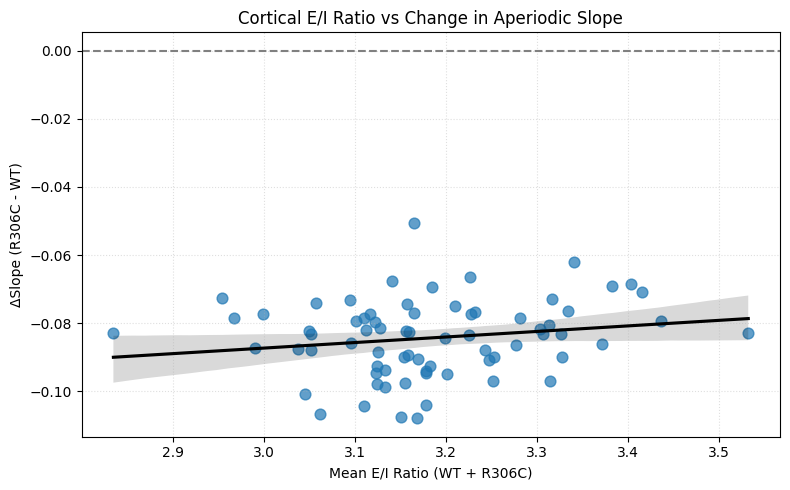

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.regplot(
    data=df_summary,
    x="E_I_Ratio",
    y="Delta_Slope",
    scatter_kws={"s": 60, "alpha": 0.7},
    line_kws={"color": "black"}
)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Mean E/I Ratio (WT + R306C)")
plt.ylabel("ΔSlope (R306C - WT)")
plt.title("Cortical E/I Ratio vs Change in Aperiodic Slope")
plt.grid(True, linestyle=":", alpha=0.4)
plt.tight_layout()
plt.show()


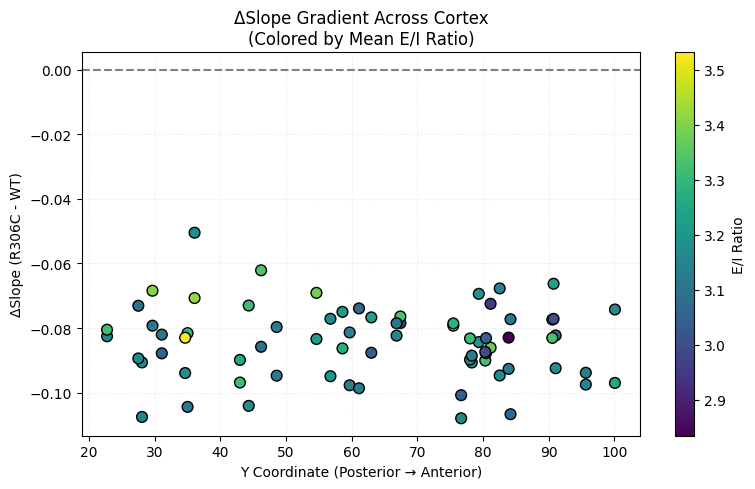

In [42]:
plt.figure(figsize=(8, 5))
sc = plt.scatter(
    df_summary["Y"],  # Anterior–Posterior coordinate
    df_summary["Delta_Slope"],
    c=df_summary["E_I_Ratio"],
    cmap="viridis",
    s=60,
    edgecolor="black"
)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Y Coordinate (Posterior → Anterior)")
plt.ylabel("ΔSlope (R306C - WT)")
plt.title("ΔSlope Gradient Across Cortex\n(Colored by Mean E/I Ratio)")
cbar = plt.colorbar(sc)
cbar.set_label("E/I Ratio")
plt.grid(True, linestyle=":", alpha=0.3)
plt.tight_layout()
plt.show()


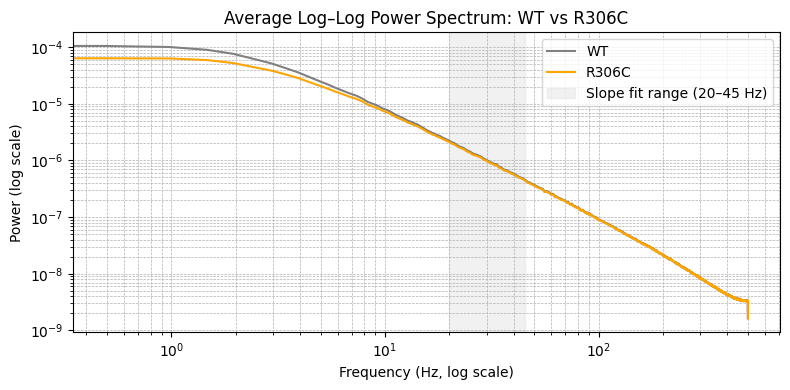

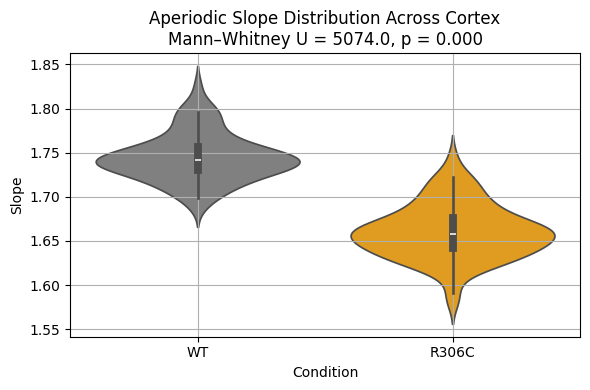

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

# === Plot 1: Average Log–Log Power Spectrum ===
freqs = results["WT"]["freqs"]
psd_wt = results["WT"]["psds"]
psd_r = results["R306C"]["psds"]

# Compute mean across regions
mean_psd_wt = np.mean(psd_wt, axis=0)
mean_psd_r = np.mean(psd_r, axis=0)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(freqs, mean_psd_wt, label="WT", color="gray")
plt.plot(freqs, mean_psd_r, label="R306C", color="orange")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz, log scale)")
plt.ylabel("Power (log scale)")
plt.title("Average Log–Log Power Spectrum: WT vs R306C")
plt.axvspan(20, 45, color='lightgray', alpha=0.3, label="Slope fit range (20–45 Hz)")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()


# Mann–Whitney U test
stat, p_value = mannwhitneyu(df_summary["Slope_WT"], df_summary["Slope_R306C"])

# Data prep
slope_data = pd.DataFrame({
    "Slope": np.concatenate([df_summary["Slope_WT"], df_summary["Slope_R306C"]]),
    "Condition": ["WT"] * len(df_summary) + ["R306C"] * len(df_summary)
})

# Plot
plt.figure(figsize=(6, 4))
sns.violinplot(x="Condition", y="Slope", data=slope_data, inner="box", hue="Condition",
               palette={"WT": "gray", "R306C": "orange"})
plt.title(f"Aperiodic Slope Distribution Across Cortex\nMann–Whitney U = {stat:.1f}, p = {p_value:.3f}")
plt.grid(True)
plt.tight_layout()
plt.show()


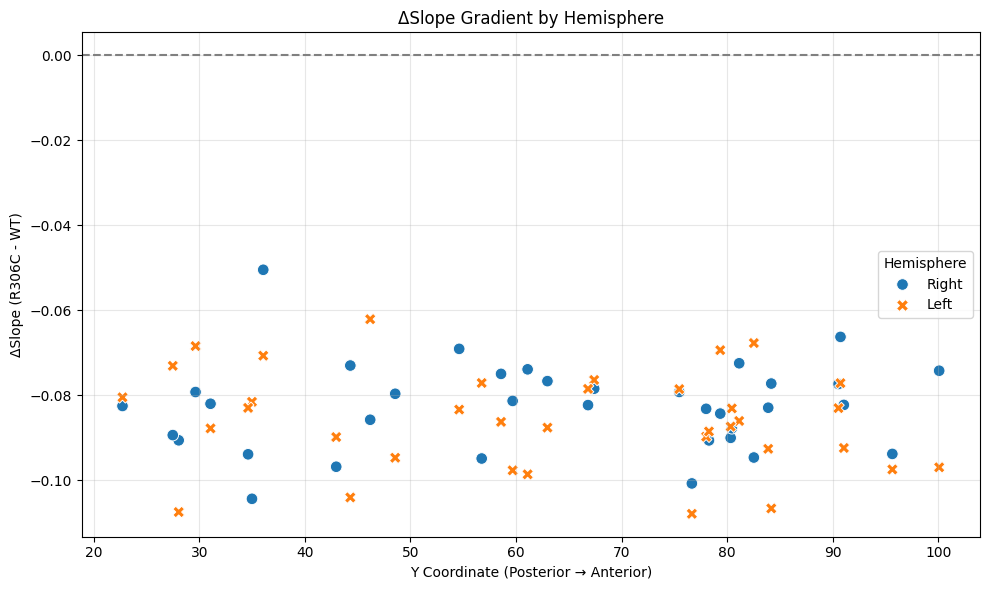

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_summary, x="Y", y="Delta_Slope", hue="Hemisphere", style="Hemisphere", s=70)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Y Coordinate (Posterior → Anterior)")
plt.ylabel("ΔSlope (R306C - WT)")
plt.title("ΔSlope Gradient by Hemisphere")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


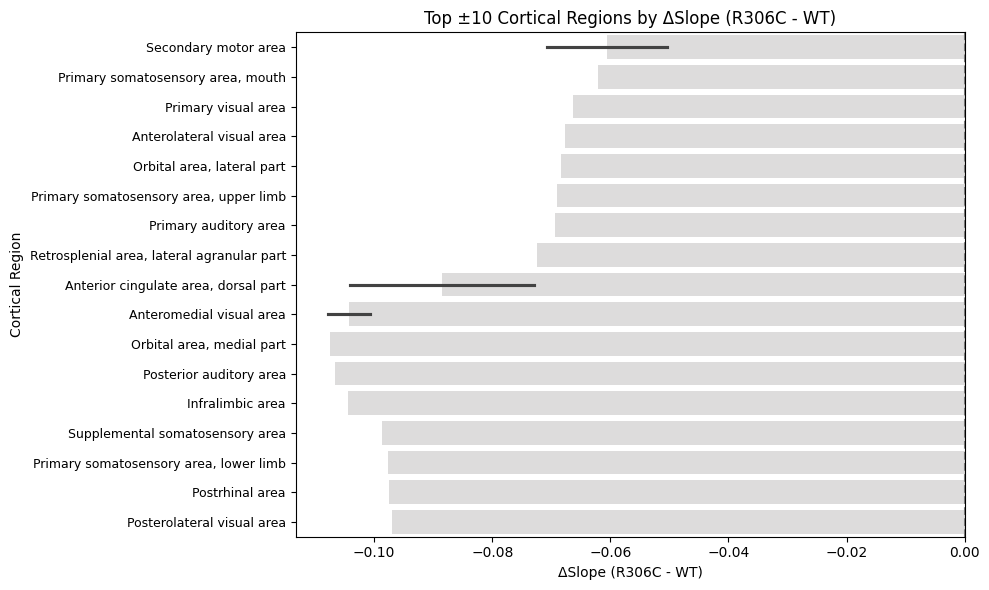

In [ ]:
# Top + bottom 10 ΔSlope regions
top_n = df_summary.nlargest(10, 'Delta_Slope')
bottom_n = df_summary.nsmallest(10, 'Delta_Slope')
top_changes = pd.concat([top_n, bottom_n])

top_changes["Rounded"] = top_changes["Delta_Slope"].round(5)
top_changes["ChangeType"] = ["Increase" if x > 0 else "Decrease" for x in top_changes["Rounded"]]


plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_changes,
    y="FullName",
    x="Delta_Slope",
    hue="ChangeType",
    palette="coolwarm",
    dodge=False
)

plt.axvline(0, color="gray", linestyle="--")
plt.title("Top ±10 Cortical Regions by ΔSlope (R306C - WT)")
plt.xlabel("ΔSlope (R306C - WT)")
plt.ylabel("Cortical Region")
plt.xticks(fontsize=10)
plt.yticks(fontsize=9)
plt.legend([], [], frameon=False) 
plt.tight_layout()
plt.show()


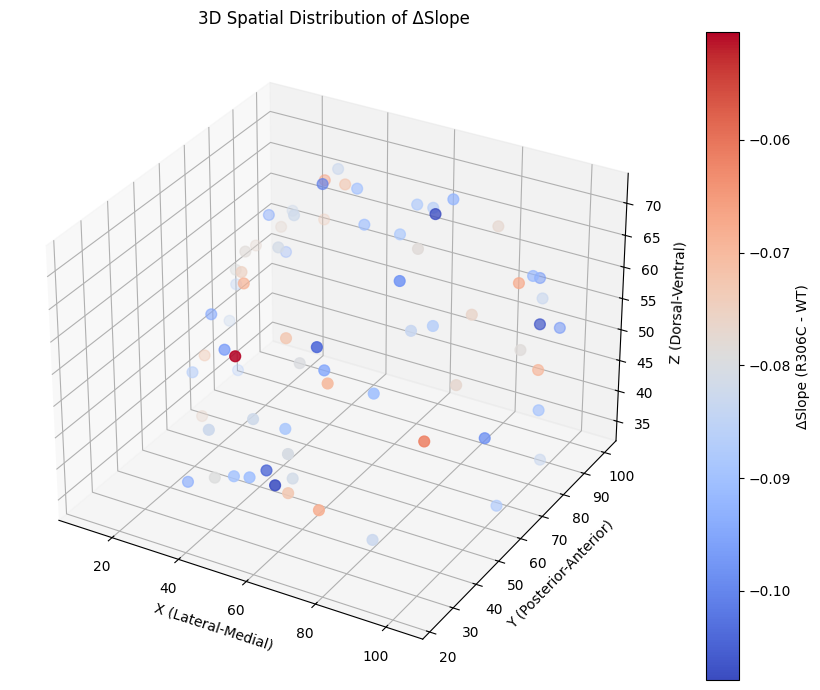

In [53]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(df_summary['X'], df_summary['Y'], df_summary['Z'],
                c=df_summary['Delta_Slope'], cmap='coolwarm', s=60)

ax.set_xlabel("X (Lateral-Medial)")
ax.set_ylabel("Y (Posterior-Anterior)")
ax.set_zlabel("Z (Dorsal-Ventral)")
fig.colorbar(sc, label="ΔSlope (R306C - WT)")
plt.title("3D Spatial Distribution of ΔSlope")
plt.tight_layout()
plt.show()


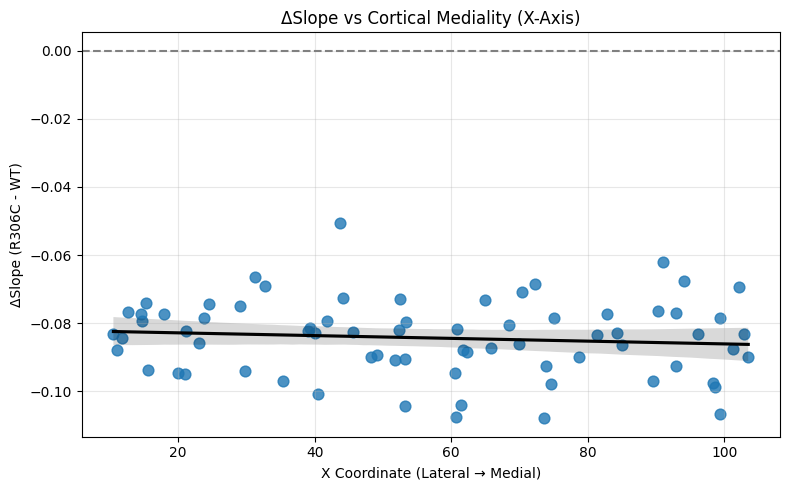

In [45]:
plt.figure(figsize=(8, 5))
sns.regplot(data=df_summary, x="X", y="Delta_Slope", scatter_kws={'s': 60}, line_kws={'color': 'black'})
plt.axhline(0, ls='--', color='gray')
plt.xlabel("X Coordinate (Lateral → Medial)")
plt.ylabel("ΔSlope (R306C - WT)")
plt.title("ΔSlope vs Cortical Mediality (X-Axis)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Text(0.5, 0.98, 'ΔSlope vs E/I Ratio, Split by Hemisphere')

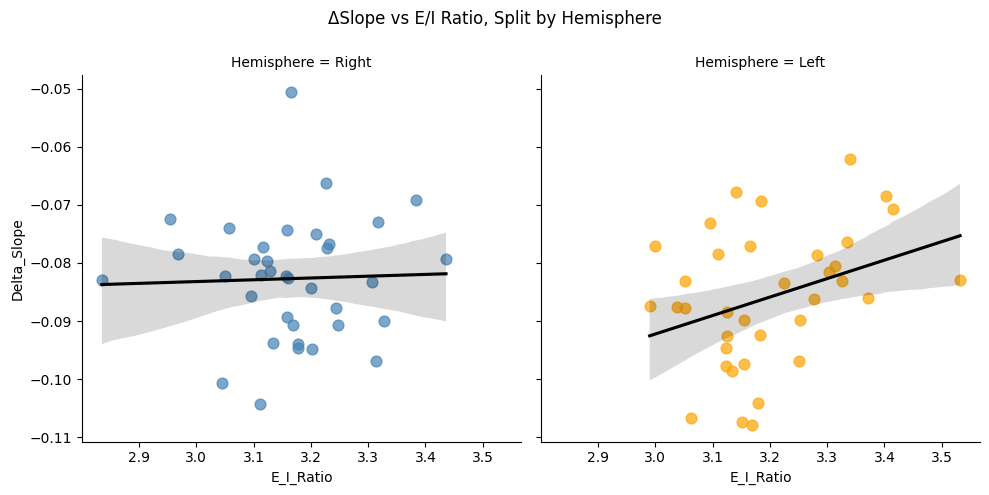

In [46]:
g = sns.lmplot(
    data=df_summary,
    x="E_I_Ratio", y="Delta_Slope",
    col="Hemisphere", hue="Hemisphere",
    palette={"Left": "orange", "Right": "steelblue"},
    height=5, aspect=1,
    scatter_kws={"s": 60, "alpha": 0.7},
    line_kws={"color": "black"}
)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("ΔSlope vs E/I Ratio, Split by Hemisphere")


In [37]:
from scipy.stats import ttest_rel
import numpy as np

# Extract slope arrays for 72 cortical regions
wt_slopes = df_summary["Slope_WT"].values
r306c_slopes = df_summary["Slope_R306C"].values

# Paired t-test
t_stat, p_val = ttest_rel(wt_slopes, r306c_slopes)
print(f"Paired t-test: t({len(wt_slopes) - 1}) = {t_stat:.2f}, p = {p_val:.2e}")

# Cohen's d for paired samples
diff = wt_slopes - r306c_slopes
cohen_d = diff.mean() / diff.std(ddof=1)
print(f"Cohen's d = {cohen_d:.2f}")


Paired t-test: t(71) = 64.20, p = 1.25e-64
Cohen's d = 7.57


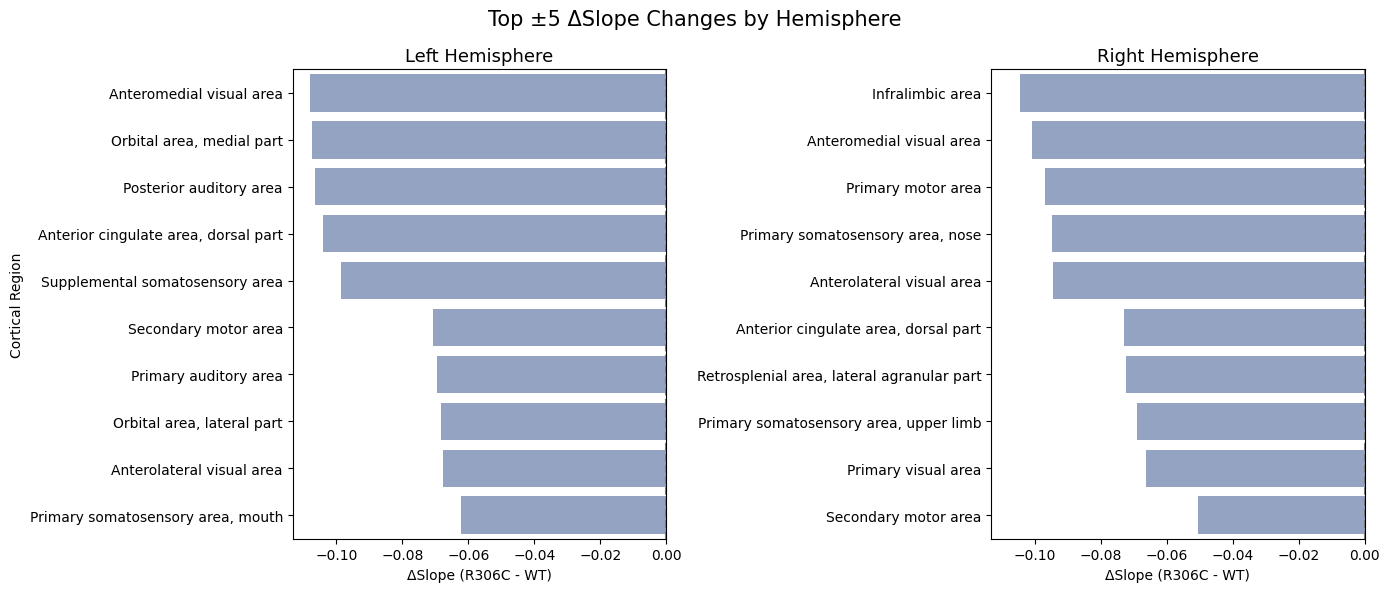

In [48]:
# Top ±5 for each hemisphere (10 total per hemisphere)
def get_top_changes_by_hemisphere(df, hemi):
    hemi_df = df[df["Hemisphere"] == hemi]
    top = hemi_df.nlargest(5, "Delta_Slope")
    bottom = hemi_df.nsmallest(5, "Delta_Slope")
    combined = pd.concat([top, bottom])
    combined["ChangeType"] = np.where(combined["Delta_Slope"] > 0, "Increase", "Decrease")
    return combined.sort_values("Delta_Slope")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

for ax, hemi in zip(axes, ["Left", "Right"]):
    subset = get_top_changes_by_hemisphere(df_summary, hemi)
    sns.barplot(
        data=subset,
        y="FullName",
        x="Delta_Slope",
        hue="ChangeType",
        dodge=False,
        palette={"Increase": "#fc8d62", "Decrease": "#8da0cb"},
        ax=ax
    )
    ax.axvline(0, color="gray", linestyle="--")
    ax.set_title(f"{hemi} Hemisphere", fontsize=13)
    ax.set_ylabel("Cortical Region" if hemi == "Left" else "")
    ax.set_xlabel("ΔSlope (R306C - WT)")
    ax.legend([], [], frameon=False)  # hide redundant legend

fig.suptitle("Top ±5 ΔSlope Changes by Hemisphere", fontsize=15)
plt.tight_layout()
plt.show()


/var/folders/h1/54gtdpj12rz7gnbmzg03rrwc0000gn/T/ipykernel_53649/345447834.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


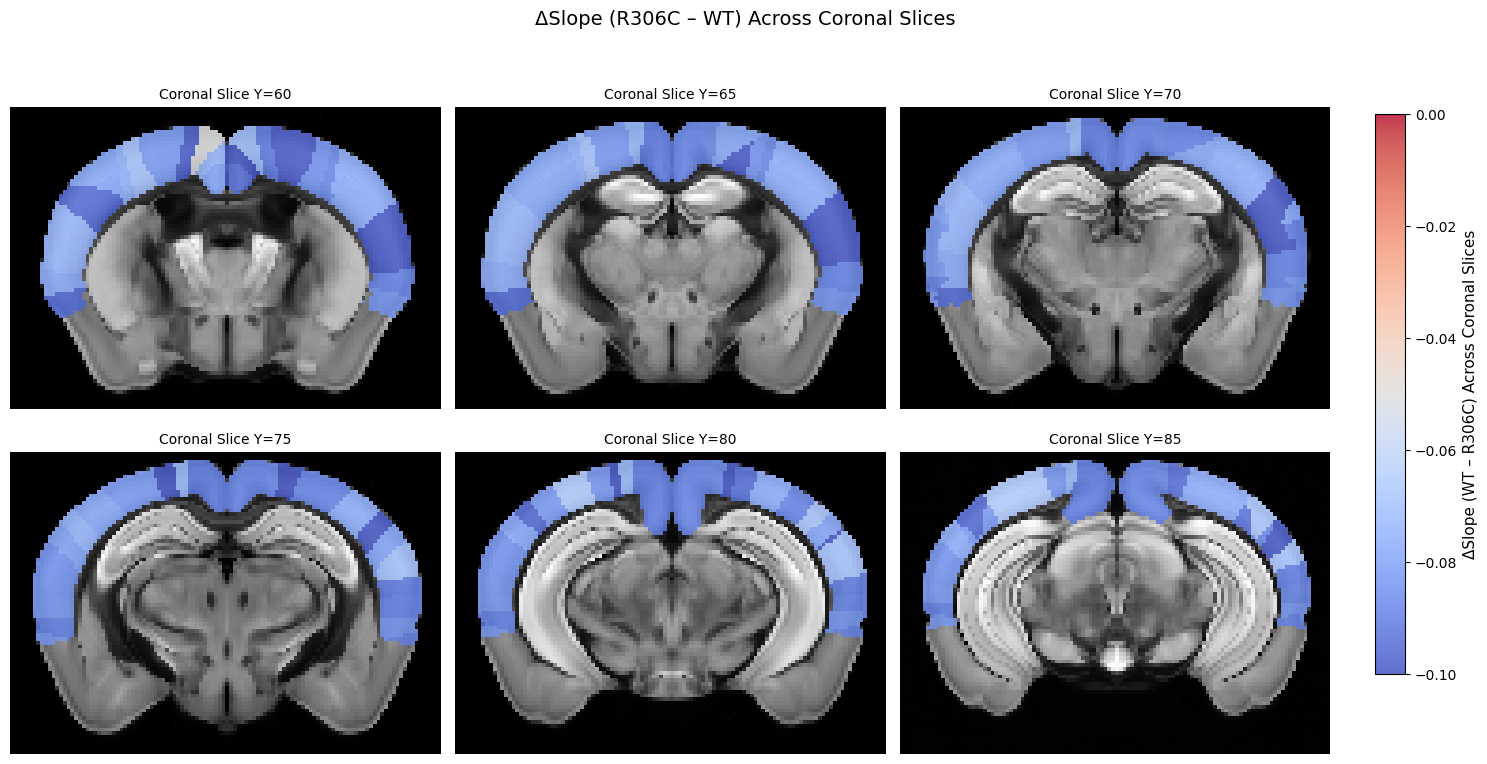

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# --- Load data ---
with h5py.File("../data/RegionVolumeMapping.h5", "r") as f:
    vol = f["array_data"][:]
with h5py.File("../data/StructuralMRI.h5", "r") as f:
    mri = f["array_data"][:]

# --- Map ΔSlope onto volume ---
vol_map = np.full_like(vol, np.nan, dtype=np.float32)
for _, row in df_summary.iterrows():
    idx = int(row["Index"])  # TVB region index
    vol_map[vol == idx] = row["Delta_Slope"]

# --- Plot multiple coronal slices ---
slices = [60, 65, 70, 75, 80, 85]  # You can tweak these
n = len(slices)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ax, slice_id in zip(axes.flat, slices):
    mri_slice = mri[:, slice_id, :].T[::-1]
    mask = np.ma.masked_invalid(vol_map[:, slice_id, :].T[::-1])
    
    ax.imshow(mri_slice, cmap="gray")
    im = ax.imshow(mask, cmap="coolwarm", vmin=-0.1, vmax=0.0, alpha=0.8)
    ax.set_title(f"Coronal Slice Y={slice_id}", fontsize=10)
    ax.axis("off")

fig.suptitle("ΔSlope (R306C – WT) Across Coronal Slices", fontsize=14)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("ΔSlope (WT – R306C) Across Coronal Slices", fontsize=11)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


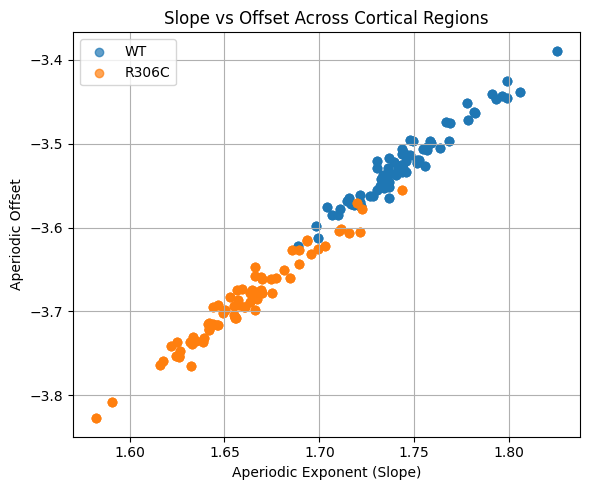

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_summary["Slope_WT"], df_summary["Offset_WT"], label="WT", alpha=0.7)
plt.scatter(df_summary["Slope_R306C"], df_summary["Offset_R306C"], label="R306C", alpha=0.7)
plt.xlabel("Aperiodic Exponent (Slope)")
plt.ylabel("Aperiodic Offset")
plt.title("Slope vs Offset Across Cortical Regions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


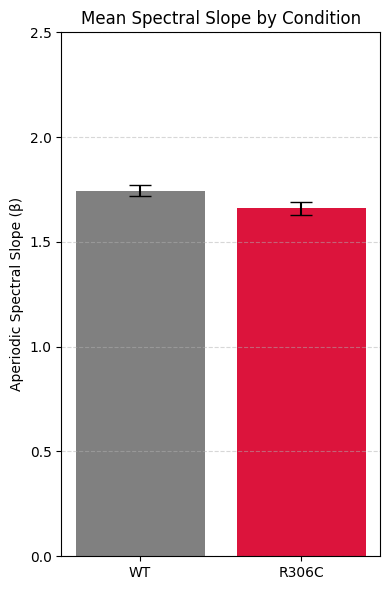

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Means and standard deviations
mean_wt = df_summary['Slope_WT'].mean()
std_wt = df_summary['Slope_WT'].std()

mean_r306c = df_summary['Slope_R306C'].mean()
std_r306c = df_summary['Slope_R306C'].std()

labels = ['WT', 'R306C']
means = [mean_wt, mean_r306c]
errors = [std_wt, std_r306c]

plt.figure(figsize=(4, 6))
plt.bar(labels, means, yerr=errors, capsize=8, color=['gray', 'crimson'])
plt.ylabel('Aperiodic Spectral Slope (β)')
plt.title('Mean Spectral Slope by Condition')
plt.ylim([0, 2.5])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


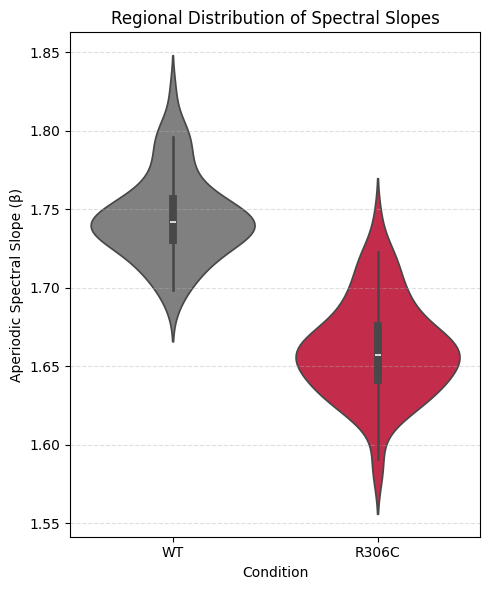

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plot_df = pd.DataFrame({
    'WT': df_summary['Slope_WT'],
    'R306C': df_summary['Slope_R306C']
}).melt(var_name='Condition', value_name='Slope')

plt.figure(figsize=(5, 6))
sns.violinplot(data=plot_df, x='Condition', y='Slope', hue='Condition',
               palette={'WT': 'gray', 'R306C': 'crimson'}, legend=False)

plt.title('Regional Distribution of Spectral Slopes')
plt.ylabel('Aperiodic Spectral Slope (β)')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
